<a href="https://colab.research.google.com/github/Abdelmalek-Djemaa/Create-a-Superhero-Name-Generator-with-TensorFlow/blob/main/Superhero_Name_Generator_with_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Superhero Name Generator


## Task 1

1. Import the data
2. Create a tokenizer
3. Char to index and Index to char dictionaries

In [3]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding , Conv1D , MaxPool1D , Dense, Bidirectional

In [4]:
with open('/content/superheroes.txt', 'r') as file:
  data = file.read()
data[:100]

'jumpa\t\ndoctor fate\t\nstarlight\t\nisildur\t\nlasher\t\nvarvara\t\nthe target\t\naxel\t\nbattra\t\nchangeling\t\npyrrh'

In [5]:
# Create an instance of the Tokenizer class from the Keras preprocessing text module
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    # Specify the characters to filter out during the tokenization process
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~',

    # Define the character to use for splitting the text into tokens
    split='\n',
)

In [6]:
# Fit the tokenizer on the provided text data
tokenizer.fit_on_texts(data)

In [7]:
# Retrieve the word-to-index mapping from the tokenizer
char_to_index = tokenizer.word_index

# Create a dictionary to map index to character
index_to_char = dict((index, char) for char, index in char_to_index.items())
print(char_to_index)

{'\t': 1, 'a': 2, 'e': 3, 'r': 4, 'o': 5, 'n': 6, 'i': 7, ' ': 8, 't': 9, 's': 10, 'l': 11, 'm': 12, 'h': 13, 'd': 14, 'c': 15, 'u': 16, 'g': 17, 'k': 18, 'b': 19, 'p': 20, 'y': 21, 'w': 22, 'f': 23, 'v': 24, 'j': 25, 'z': 26, 'x': 27, 'q': 28}


## Task 2

1. Converting between names and sequences

In [8]:
names = data.split('\n')
names[:10]

['jumpa\t',
 'doctor fate\t',
 'starlight\t',
 'isildur\t',
 'lasher\t',
 'varvara\t',
 'the target\t',
 'axel\t',
 'battra\t',
 'changeling\t']

In [9]:
tokenizer.texts_to_sequences(names[0])

[[25], [16], [12], [20], [2], [1]]

In [10]:
def name_to_sequence(name):
  return [tokenizer.word_index[char] for char in name]

In [11]:
name_to_sequence(names[0])

[25, 16, 12, 20, 2, 1]

In [12]:
def sequence_to_name(sequence):
  return ''.join([index_to_char[index] for index in sequence])

In [13]:
sequence_to_name(name_to_sequence(names[0]))

'jumpa\t'

## Task 3

1. Creating sequences
2. Padding all sequences

In [14]:
name_sequences = []

for name in names:
    sequence = name_to_sequence(name)  # Convert the name to a sequence of tokens or indices

    # Check if the length of the sequence is at least 2
    if len(sequence) >= 2:
        # Generate subsequences of lengths 2 up to the length of the sequence
        name_sequences += [sequence[:i] for i in range(2, len(sequence) + 1)]

name_sequences[:10]


[[25, 16],
 [25, 16, 12],
 [25, 16, 12, 20],
 [25, 16, 12, 20, 2],
 [25, 16, 12, 20, 2, 1],
 [14, 5],
 [14, 5, 15],
 [14, 5, 15, 9],
 [14, 5, 15, 9, 5],
 [14, 5, 15, 9, 5, 4]]

In [15]:
max_len = max([len(sequence) for sequence in name_sequences])
print(max_len)

33


In [16]:
# Pad sequences to ensure uniform length
padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(
    name_sequences,  # List of sequences to pad
    maxlen=max_len,   # Maximum length to pad sequences to
    padding='pre',    # Padding position ('pre' means padding is added at the beginning of sequences)
)
padded_sequences

array([[ 0,  0,  0, ...,  0, 25, 16],
       [ 0,  0,  0, ..., 25, 16, 12],
       [ 0,  0,  0, ..., 16, 12, 20],
       ...,
       [ 0,  0,  0, ..., 11,  5, 20],
       [ 0,  0,  0, ...,  5, 20, 10],
       [ 0,  0,  0, ..., 20, 10,  1]], dtype=int32)

In [17]:
padded_sequences.shape

(88279, 33)

## Task 4: Creating Training and Validation Sets

1. Creating training and validation sets

In [18]:
x = padded_sequences[:, :-1]
y = padded_sequences[:, -1]
print(x.shape , y.shape)

(88279, 32) (88279,)


In [19]:
x_train , x_test , y_train , y_test = train_test_split(x , y , test_size = 0.2 , random_state = 42)
print(x_train.shape , y_train.shape)
print(x_test.shape , y_test.shape)

(70623, 32) (70623,)
(17656, 32) (17656,)


## Task 5: Creating the Model

In [37]:
model = Sequential([
    Embedding(input_dim=len(char_to_index) + 1, output_dim=16, input_length=max_len - 1),
    Conv1D(filters=64, kernel_size=5, padding='causal', activation='relu'),
    MaxPool1D(pool_size=2),
    LSTM(units=128),
    tf.keras.layers.Flatten(),
    Dense(units=len(char_to_index) + 1, activation='softmax'),
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
    )

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 32, 16)            464       
                                                                 
 conv1d_6 (Conv1D)           (None, 32, 64)            5184      
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 16, 64)            0         
 g1D)                                                            
                                                                 
 lstm_6 (LSTM)               (None, 128)               98816     
                                                                 
 flatten_3 (Flatten)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 29)                3741      
                                                      

In [39]:
history = model.fit(
    x_train,
    y_train,
    epochs=20,
    verbose = 2 ,
    validation_data = (x_test, y_test),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)],
    )

Epoch 1/20
2207/2207 - 17s - loss: 2.6745 - accuracy: 0.2048 - val_loss: 2.5180 - val_accuracy: 0.2326 - 17s/epoch - 8ms/step
Epoch 2/20
2207/2207 - 11s - loss: 2.4501 - accuracy: 0.2588 - val_loss: 2.3884 - val_accuracy: 0.2748 - 11s/epoch - 5ms/step
Epoch 3/20
2207/2207 - 14s - loss: 2.3432 - accuracy: 0.2868 - val_loss: 2.3095 - val_accuracy: 0.3032 - 14s/epoch - 6ms/step
Epoch 4/20
2207/2207 - 11s - loss: 2.2560 - accuracy: 0.3138 - val_loss: 2.2594 - val_accuracy: 0.3172 - 11s/epoch - 5ms/step
Epoch 5/20
2207/2207 - 12s - loss: 2.1775 - accuracy: 0.3390 - val_loss: 2.2066 - val_accuracy: 0.3317 - 12s/epoch - 5ms/step
Epoch 6/20
2207/2207 - 12s - loss: 2.1063 - accuracy: 0.3615 - val_loss: 2.1642 - val_accuracy: 0.3491 - 12s/epoch - 5ms/step
Epoch 7/20
2207/2207 - 14s - loss: 2.0426 - accuracy: 0.3834 - val_loss: 2.1362 - val_accuracy: 0.3598 - 14s/epoch - 6ms/step
Epoch 8/20
2207/2207 - 15s - loss: 1.9838 - accuracy: 0.4010 - val_loss: 2.1161 - val_accuracy: 0.3653 - 15s/epoch - 7

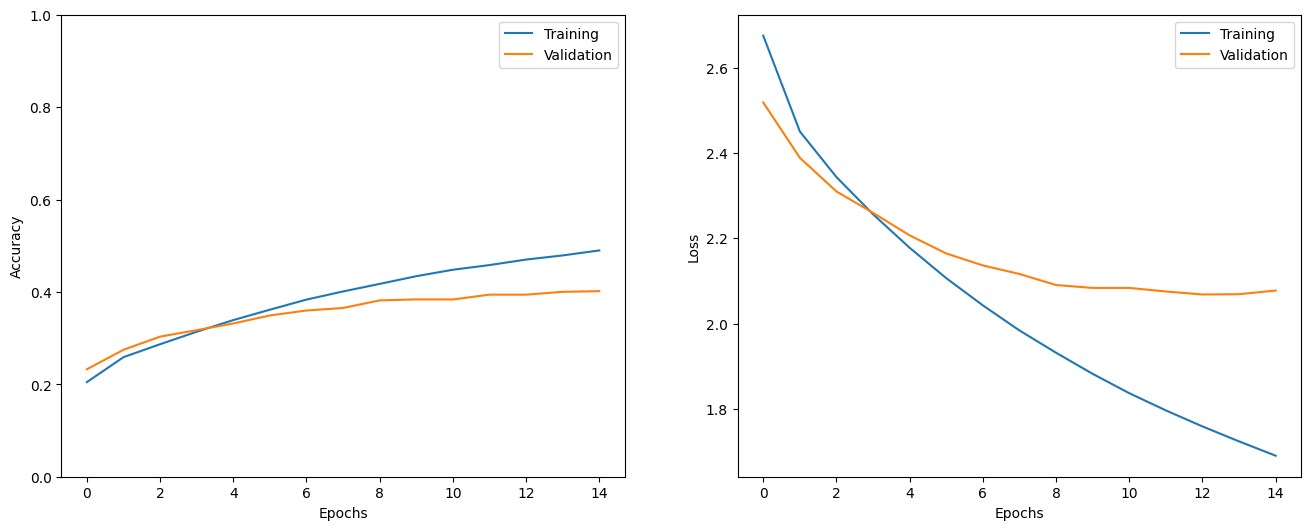

In [40]:
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


show_history(history)

## Task 6 : Generate names

In [52]:
def generate_names(seed):
  for _ in range(40):
    input_sequence = name_to_sequence(seed)
    padded_sequence = tf.keras.preprocessing.sequence.pad_sequences([input_sequence], truncating="pre", padding='pre', maxlen=max_len - 1)
    predicted_index = np.argmax(model.predict(padded_sequence))
    predicted_char = index_to_char[predicted_index]
    seed += predicted_char
    if predicted_char == '\t':
      break
  return seed[:-1]

In [72]:
generate_names('dark')

1/1 [==============================] - 0s 17ms/step


'dark phoenix'